
remove comment below to download required libraries

In [2]:
#pip install streamlit folium streamlit-folium

In [5]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import xarray as xr
from IPython.display import display

# Machine Learning libraries
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error

#Mapping

import folium
import geopandas as gpd

In [6]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("harlfoxem/housesalesprediction")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/housesalesprediction


In [7]:
import os

# Your dataset path
dataset_path = "/kaggle/input/housesalesprediction"

# List all files to find the correct CSV file name
print(os.listdir(dataset_path))

['kc_house_data.csv']


In [8]:
df = pd.read_csv(os.path.join(dataset_path, "kc_house_data.csv"))
df.head()  # Show first 5 rows

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [10]:
df['date'] = pd.to_datetime(df['date'], format='%Y%m%dT%H%M%S')

# Create new features
df['price_per_sqft'] = df['price'] / df['sqft_living']

In [11]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price_per_sqft
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,...,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,188.050847
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,...,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,209.338521
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,...,770,0,1933,0,98028,47.7379,-122.233,2720,8062,233.766234
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,0,...,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,308.163265
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,...,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,303.571429


In [12]:
df.isnull().sum()

,0
id,0
date,0
price,0
bedrooms,0
bathrooms,0
sqft_living,0
sqft_lot,0
floors,0
waterfront,0
view,0


In [13]:
# Normalize
# Calculate a normalized investment score based on affordability (inverse of price per square foot)
# and property quality (sum of condition, grade, view, and waterfront). The two components are equally weighted
# using percentile ranks to produce a final score on a 0–100 scale.
df['affordability_score'] = 1 / df['price_per_sqft']
df['quality_score'] = df['condition'] + df['grade'] + df['view'] + df['waterfront']

# Combine
df['investment_score'] = (
    df['affordability_score'].rank(pct=True) * 0.5 +
    df['quality_score'].rank(pct=True) * 0.5
) * 100

In [15]:
print(df.columns.tolist())

['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'price_per_sqft', 'affordability_score', 'quality_score', 'investment_score']


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127968 (\N{HOUSE BUILDING}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


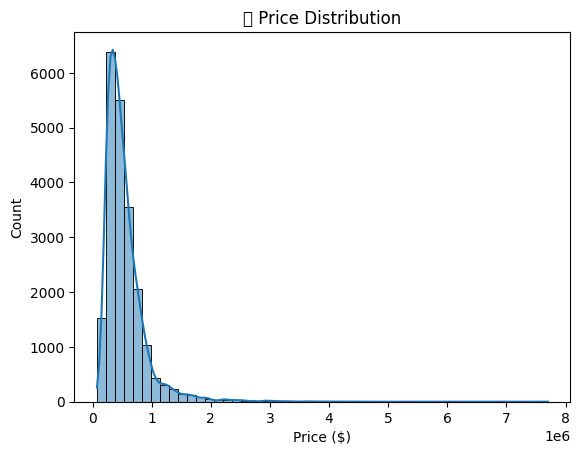

In [17]:
sns.histplot(df['price'], bins=50, kde=True)
plt.title("Price Distribution")
plt.xlabel("Price ($)")
plt.ylabel("Count")
plt.show()

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


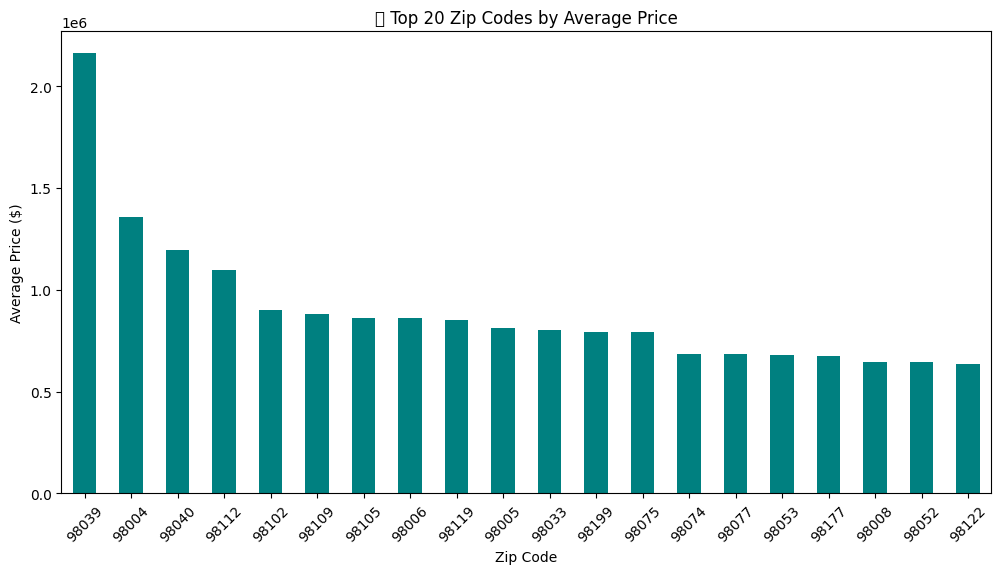

In [18]:
zip_avg = df.groupby('zipcode')['price'].mean().sort_values(ascending=False)

plt.figure(figsize=(12,6))
zip_avg.head(20).plot(kind='bar', color='teal')
plt.title("Top 20 Zip Codes by Average Price")
plt.ylabel("Average Price ($)")
plt.xlabel("Zip Code")
plt.xticks(rotation=45)
plt.show()

<ipython-input-19-794696fbde30>:11: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


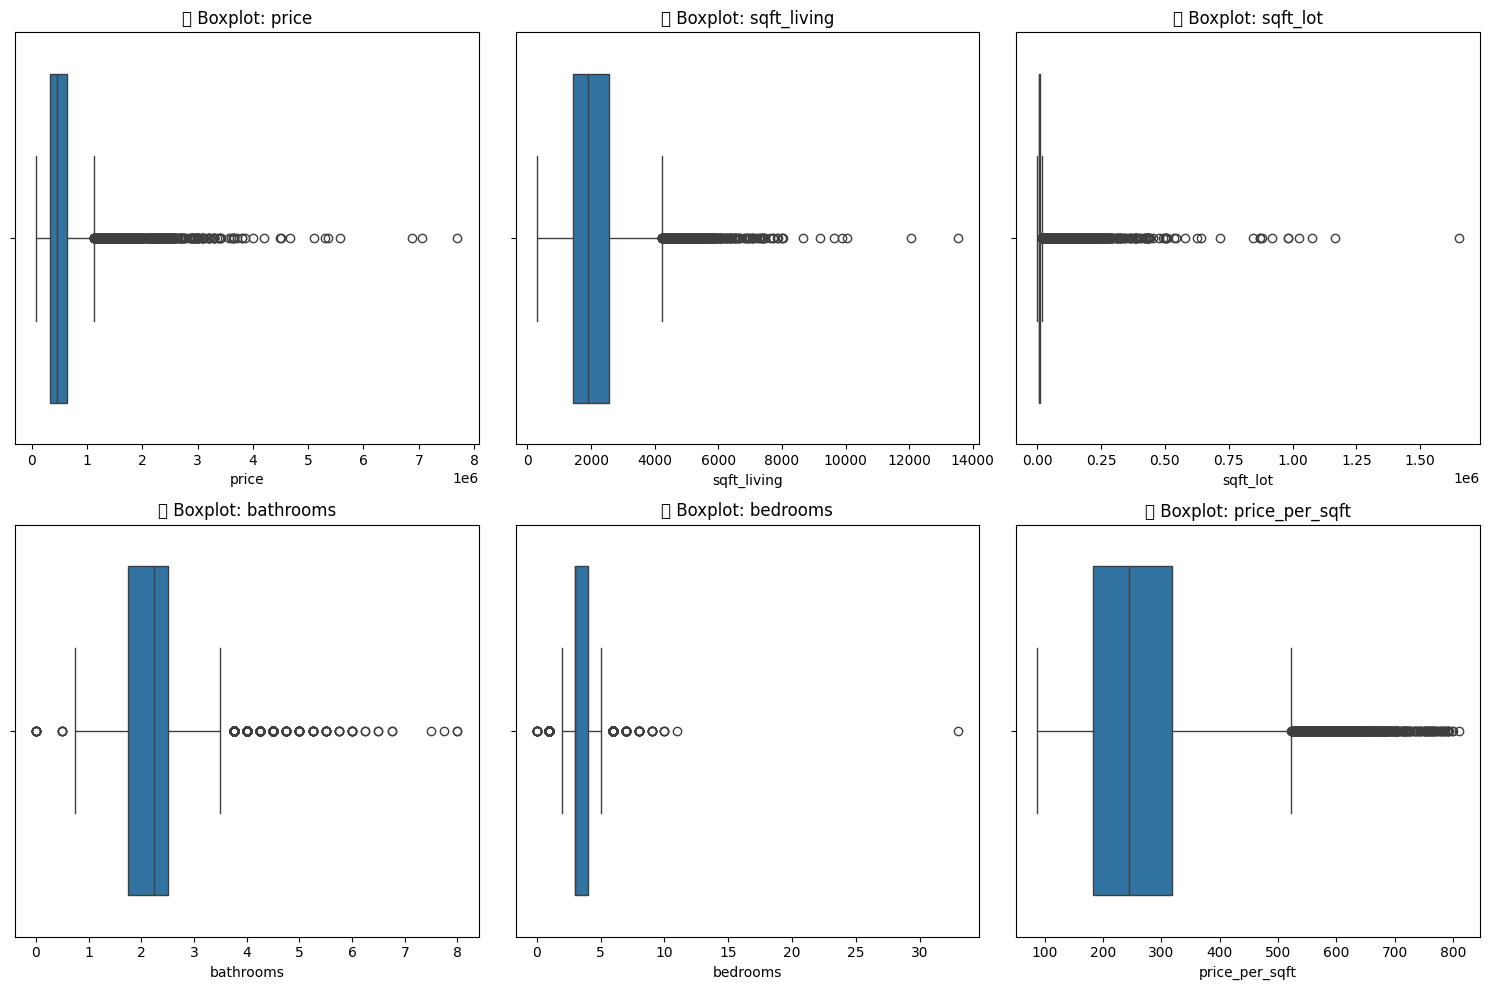

In [19]:
features_to_check = ['price', 'sqft_living', 'sqft_lot', 'bathrooms', 'bedrooms', 'price_per_sqft']

plt.figure(figsize=(15, 10))
for i, feature in enumerate(features_to_check):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x=df[feature])
    plt.title(f'Boxplot: {feature}')
plt.tight_layout()
plt.show()

In [20]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price_per_sqft,affordability_score,quality_score,investment_score
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,...,0,98178,47.5112,-122.257,1340,5650,188.050847,0.005318,10,46.165502
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,...,1991,98125,47.7210,-122.319,1690,7639,209.338521,0.004777,10,41.841716
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,...,0,98028,47.7379,-122.233,2720,8062,233.766234,0.004278,9,28.989497
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,0,...,0,98136,47.5208,-122.393,1360,5000,308.163265,0.003245,12,50.719474
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,...,0,98074,47.6168,-122.045,1800,7503,303.571429,0.003294,11,38.783371


In [21]:
# Feature Engineering:
# Derive additional structural, pricing, and location-based features to enrich the dataset.
# - total_sqft: combined living and lot area
# - house_age: age of the home relative to 2025
# - is_renovated: binary flag for renovated homes
# - price_per_sqft: normalized pricing metric
# - log_price: log transformation for price normalization
# - price_rank_by_zip: percentile-based price rank within each ZIP code
# - property_quality: combined indicator of structural quality and locational desirability

df['total_sqft'] = df['sqft_living'] + df['sqft_lot']
df['house_age'] = 2025 - df['yr_built']
df['is_renovated'] = df['yr_renovated'].apply(lambda x: 1 if x > 0 else 0)

# Pricing Insight
df['price_per_sqft'] = df['price'] / df['sqft_living']
df['log_price'] = np.log1p(df['price'])

# Zipcode-Based (price ranking)
df['price_rank_by_zip'] = df.groupby('zipcode')['price'].rank(pct=True)

# Composite Score Idea (just for fun)
df['property_quality'] = df['grade'] + df['condition'] + df['view'] + df['waterfront']

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128178 (\N{HEAVY DOLLAR SIGN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


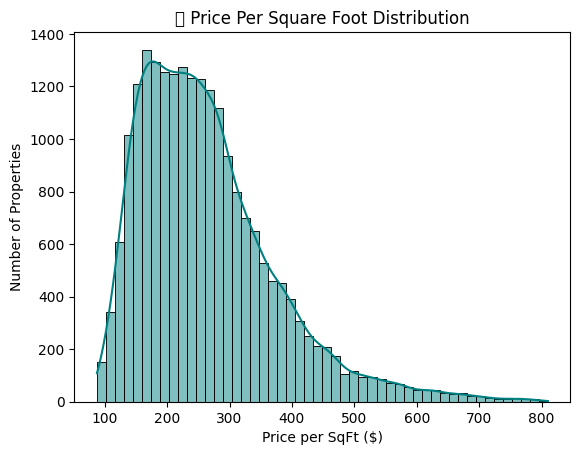

In [22]:
sns.histplot(df['price_per_sqft'], kde=True, bins=50, color='teal')
plt.title("Price Per Square Foot Distribution")
plt.xlabel("Price per SqFt ($)")
plt.ylabel("Number of Properties")
plt.show()

In [23]:
features_to_keep = [
    'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'floors',
    'waterfront', 'view', 'condition', 'grade','yr_built','yr_renovated','zipcode', 'lat', 'long',
    'price_per_sqft', 'affordability_score', 'quality_score', 'investment_score'
]

In [24]:
df_filtered = df[features_to_keep]

downaload data

In [26]:
#df_filtered.to_csv("filtered_real_estate_data.csv", index=False)
#from google.colab import files
#files.download("filtered_real_estate_data.csv")

In [28]:
df_filtered.info()
df_filtered.describe().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 21613 non-null  datetime64[ns]
 1   price                21613 non-null  float64       
 2   bedrooms             21613 non-null  int64         
 3   bathrooms            21613 non-null  float64       
 4   sqft_living          21613 non-null  int64         
 5   floors               21613 non-null  float64       
 6   waterfront           21613 non-null  int64         
 7   view                 21613 non-null  int64         
 8   condition            21613 non-null  int64         
 9   grade                21613 non-null  int64         
 10  yr_built             21613 non-null  int64         
 11  yr_renovated         21613 non-null  int64         
 12  zipcode              21613 non-null  int64         
 13  lat                  21613 non-

,count,mean,min,25%,50%,75%,max,std
date,21613,2014-10-29 04:38:01.959931648,2014-05-02 00:00:00,2014-07-22 00:00:00,2014-10-16 00:00:00,2015-02-17 00:00:00,2015-05-27 00:00:00,NaN
price,21613.0,540088.141767,75000.0,321950.0,450000.0,645000.0,7700000.0,367127.196483
bedrooms,21613.0,3.370842,0.0,3.0,3.0,4.0,33.0,0.930062
bathrooms,21613.0,2.114757,0.0,1.75,2.25,2.5,8.0,0.770163
sqft_living,21613.0,2079.899736,290.0,1427.0,1910.0,2550.0,13540.0,918.440897
floors,21613.0,1.494309,1.0,1.0,1.5,2.0,3.5,0.539989
waterfront,21613.0,0.007542,0.0,0.0,0.0,0.0,1.0,0.086517
view,21613.0,0.234303,0.0,0.0,0.0,0.0,4.0,0.766318
condition,21613.0,3.40943,1.0,3.0,3.0,4.0,5.0,0.650743
grade,21613.0,7.656873,1.0,7.0,7.0,8.0,13.0,1.175459


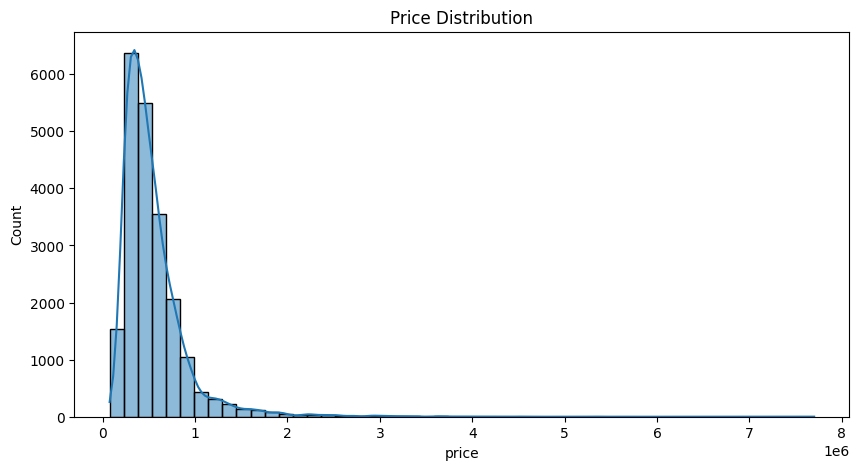

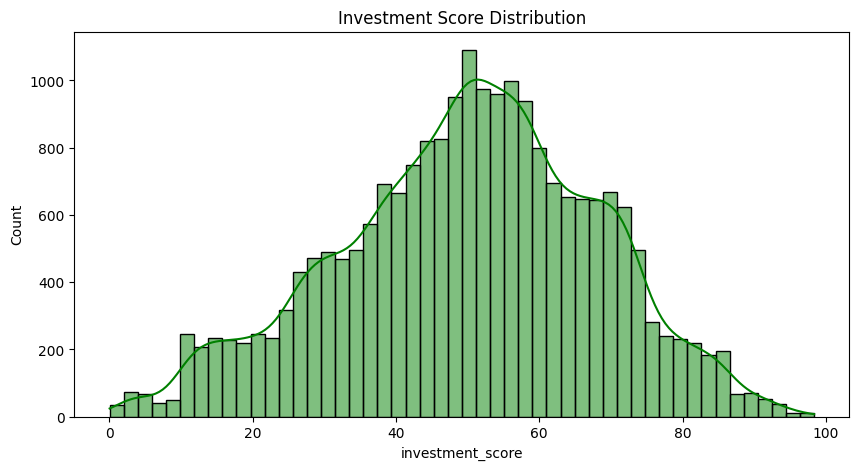

In [29]:
plt.figure(figsize=(10,5))
sns.histplot(df_filtered['price'], bins=50, kde=True)
plt.title("Price Distribution")
plt.show()

plt.figure(figsize=(10,5))
sns.histplot(df_filtered['investment_score'], bins=50, kde=True, color='green')
plt.title("Investment Score Distribution")
plt.show()

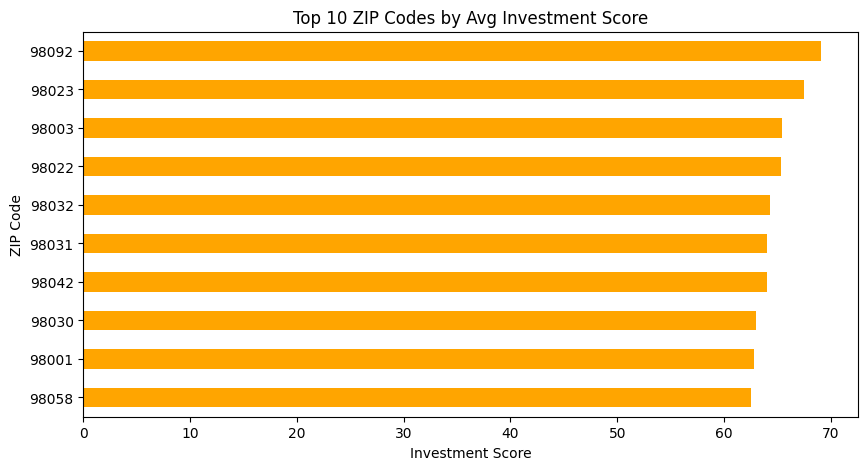

In [30]:
zip_investment = df_filtered.groupby("zipcode")["investment_score"].mean().sort_values(ascending=False).head(10)

zip_investment.plot(kind='barh', color='orange', figsize=(10,5))
plt.title("Top 10 ZIP Codes by Avg Investment Score")
plt.xlabel("Investment Score")
plt.ylabel("ZIP Code")
plt.gca().invert_yaxis()
plt.show()

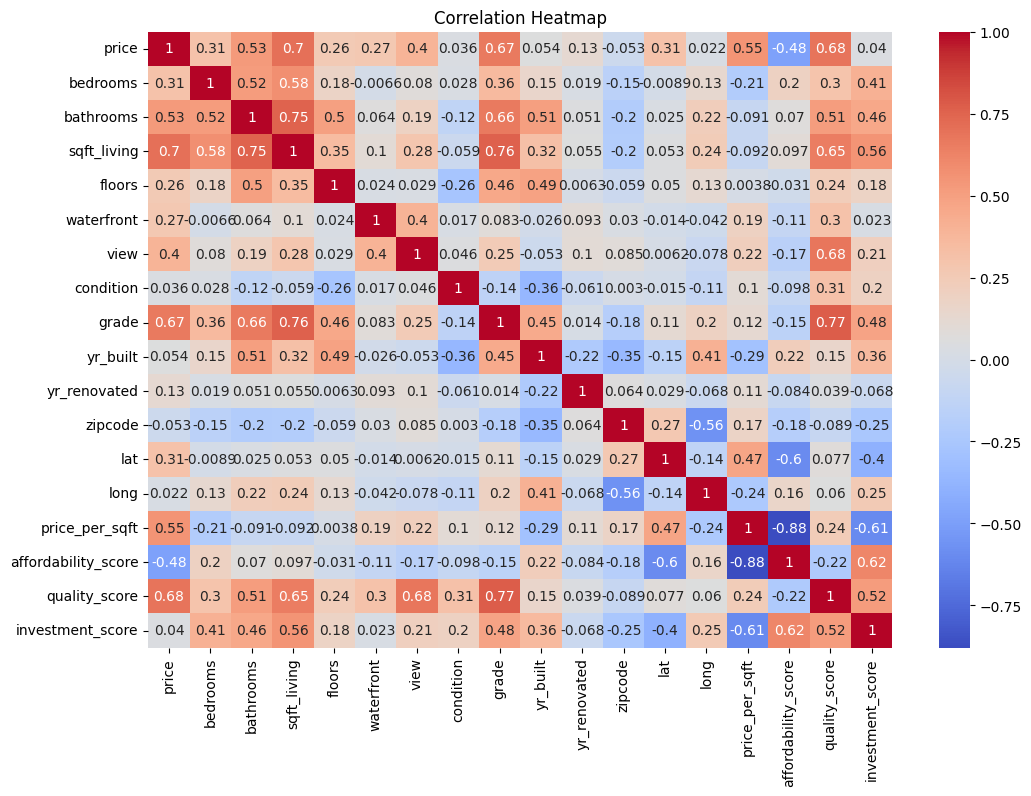

In [31]:
plt.figure(figsize=(12,8))
sns.heatmap(df_filtered.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

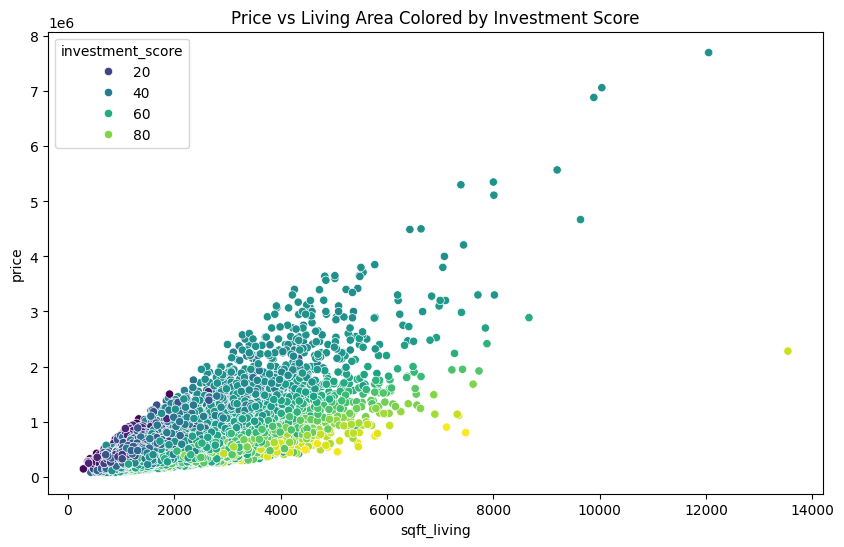

In [32]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=df_filtered, x="sqft_living", y="price", hue="investment_score", palette="viridis")
plt.title("Price vs Living Area Colored by Investment Score")
plt.show()

<ipython-input-40-c86b0a022dd4>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=top_zipcodes.values, y=[str(i) for i in range(len(top_zipcodes))], palette="magma")


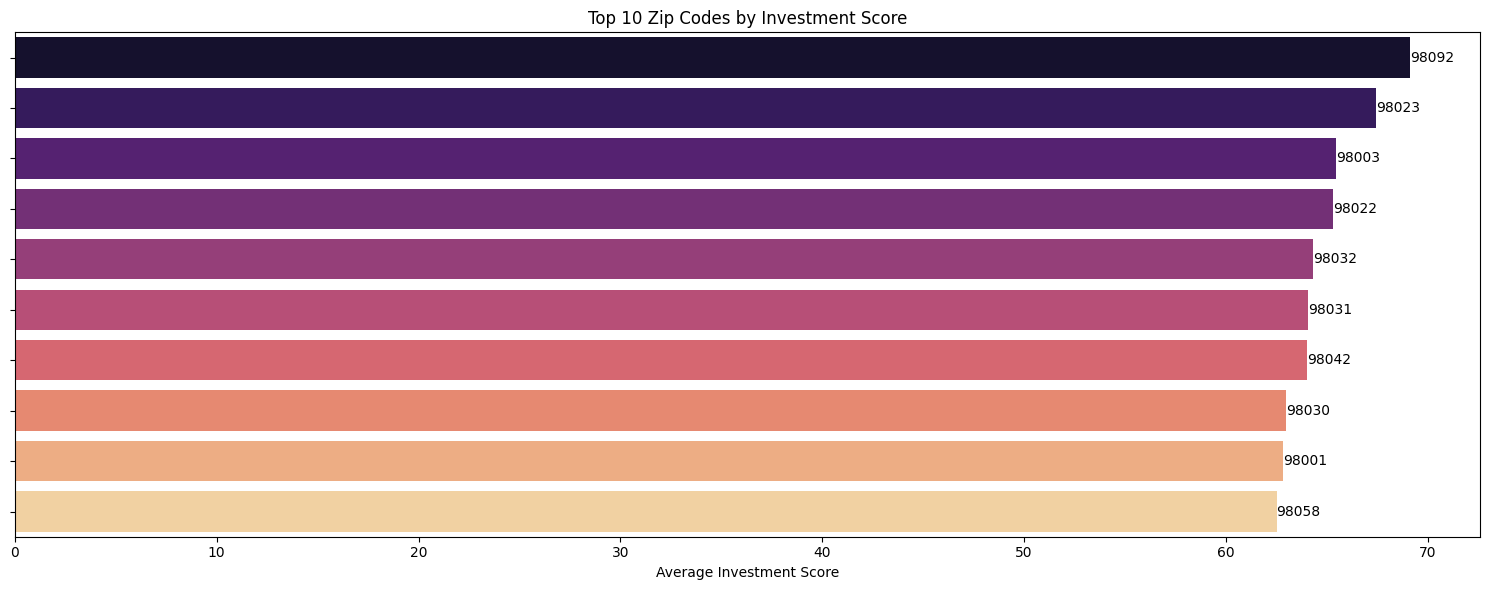

In [40]:
plt.figure(figsize=(15, 6))
ax = sns.barplot(x=top_zipcodes.values, y=[str(i) for i in range(len(top_zipcodes))], palette="magma")

# Annotate each bar with the ZIP code above the bar
for i, (score, zipcode) in enumerate(zip(top_zipcodes.values, top_zipcodes.index)):
    ax.text(score, i, f"{zipcode}", va='center', ha='left', fontsize=10, color='black')

# Customize labels and title
plt.xlabel("Average Investment Score")
plt.ylabel("")
ax.set_yticklabels([])  # Remove y-axis ticks
plt.title("Top 10 Zip Codes by Investment Score")
plt.tight_layout()
plt.show()

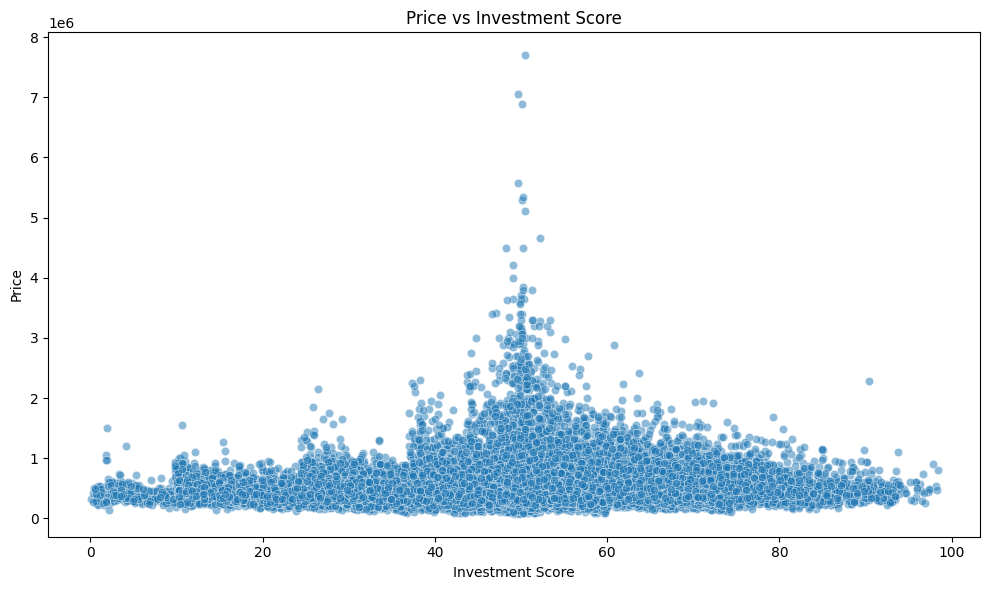

In [38]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='investment_score', y='price', data=df, alpha=0.5)
plt.title("Price vs Investment Score")
plt.xlabel("Investment Score")
plt.ylabel("Price")
plt.tight_layout()
plt.show()